In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import warnings
import gc
import lightgbm as lgbm
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error
import imageio.v2 as imageio
from tqdm.notebook import tqdm
from itertools import product

pd.set_option('display.max_columns', 999)
# plt.rc('figure', figsize=(20, 10))
# plt.rc('font', size=20)
# warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../train_data.csv')

In [3]:
test = pd.read_csv('../test.csv').rename(columns={'hour': 'timestamp'})

In [4]:
coordinates_edges = {'lat': (59.656929822910136, 60.374089897957774),
                     'lon': (29.40635082565253, 32.047397760963925)}

In [5]:
df[['lon', 'lat']].agg(['max', 'min'])

,lon,lat
max,137.136811,60.374090
min,-48.410211,-1.390007


There are some outliers in coordinates, we have to remove them.

In [6]:
for col in ('lat', 'lon'):
    df = df[(df[col] > coordinates_edges[col][0]) & (df[col] < coordinates_edges[col][1])]

In [7]:
un_lat = df.lat.unique()
un_lon = df.lon.unique()

In [8]:
len(un_lat), len(un_lon)

(209, 217)

In [9]:
len(df)

8450458

In [10]:
hp = {
    'train_polygons_threshold': 2000,
    'known_lag': 24*7*4,
    'n_val_trials': 10,
    'metric': 'rmse'
}

In [11]:
poly = df.groupby(['lon', 'lat']).likescount.count().rename('poly_count').reset_index()
poly = poly[poly.poly_count > hp['train_polygons_threshold']][['lon', 'lat']]

In [12]:
df_new = pd.merge(df, poly, on=['lon', 'lat'])
len(df_new.timestamp.unique())

9504

In [13]:
df_new.head()

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point
0,1565607600,30.32937,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,1565571600,30.32937,59.940488,6,0,18,3,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
2,1565582400,30.32937,59.940488,12,0,169,3,10,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
3,1565582400,30.32937,59.940488,8,0,63,5,1,0,0,1,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
4,1565582400,30.32937,59.940488,110,2,26,3,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...


## aggregate data

In [14]:
feature_names = [
    'likescount',
    'commentscount',
    'symbols_cnt',
    'words_cnt',
    'hashtags_cnt',
    'mentions_cnt',
    'links_cnt',
    'emoji_cnt',
]

In [15]:
%%time
data = df_new.groupby(['timestamp', 'lon', 'lat'])[feature_names].agg([np.mean, np.std, np.min, np.max, 'count']).fillna(0)
data.columns = [f'{col1}_{col2}' for col1, col2 in data.columns]
data = data.rename(columns={'likescount_count': 'posts_count'})
data = data.drop(columns=[f'{feature}_count' for feature in feature_names if feature != 'likescount'])
data = data.reset_index()
data['datetime'] = data['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x))
data = data.set_index('datetime')

CPU times: total: 14.9 s
Wall time: 14.9 s


In [16]:
%%time
data_full = df.groupby(['timestamp', 'lon', 'lat'])[feature_names].agg([np.mean, np.std, np.min, np.max, 'count']).fillna(0)
data_full.columns = [f'{col1}_{col2}' for col1, col2 in data_full.columns]
data_full = data_full.rename(columns={'likescount_count': 'posts_count'})
data_full = data_full.drop(columns=[f'{feature}_count' for feature in feature_names if feature != 'likescount'])
data_full = data_full.reset_index()
data_full['datetime'] = data_full['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x))
data_full = data_full.set_index('datetime')

CPU times: total: 15.8 s
Wall time: 15.8 s


## gif prepare

In [17]:
data_full['date'] = data_full.index.date.astype(str)
data['date'] = data.index.date.astype(str)
test['date'] = pd.to_datetime(test.timestamp, unit='s').dt.date.astype(str)

data_full['date'] = data_full['date'].str[:-3]
data['date'] = data['date'].str[:-3]
test['date'] = test['date'].str[:-3]

temp_data_full = data_full.groupby(['date', 'lat', 'lon'])['posts_count'].sum().reset_index()
temp_data = data.groupby(['date', 'lat', 'lon'])['posts_count'].sum().reset_index()
temp_test = test.groupby(['date', 'lat', 'lon'])['sum'].sum().reset_index()

In [18]:
def save_instance(date, filename, title, basepath = './gif/'):
    instance_full = temp_data_full[temp_data_full['date'] == date]
    instance = temp_data[temp_data['date'] == date]
    instance_test = temp_test[temp_test['date'] == date]
    
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.scatter(instance_full['lat'], instance_full['lon'], s=0.1*(instance_full.posts_count), color='royalblue', alpha=0.25, label='full data', zorder=2)
#     ax.scatter(instance['lat'], instance['lon'], s=0.05*(instance.posts_count), color='seagreen', alpha=0.7, label='train data', zorder=2)
#     ax.scatter(instance_test['lat'], instance_test['lon'], s=(instance_test['sum']), color='r', label='test data', zorder=2)
    ax.set_xlabel('lat')
    ax.set_ylabel('lon')
    ax.set_xlim(59.82, 60.05)
    ax.set_ylim(30.09, 30.6)
    leg = ax.legend(loc='upper right')

    ax.grid(color='lightblue', zorder=0, lw=0.2)
    fig.tight_layout()
    fig.savefig(f'{basepath}{filename}', dpi=200)
    plt.close()

In [19]:
unique_dates = temp_data_full['date'].sort_values().unique()
filenames = []
for ts in tqdm(unique_dates[:-1]):
    filenames.append(str(ts))
    save_instance(
        date=ts,
        filename=filenames[-1],
        title=str(ts),
    )

  0%|          | 0/13 [00:00<?, ?it/s]

In [131]:
%%time
with imageio.get_writer('gif1.gif', mode='I') as writer:
    for fn in filenames:
        image = imageio.imread(f'./gif/{fn}.png')
        writer.append_data(image)

CPU times: total: 1.14 s
Wall time: 1.15 s


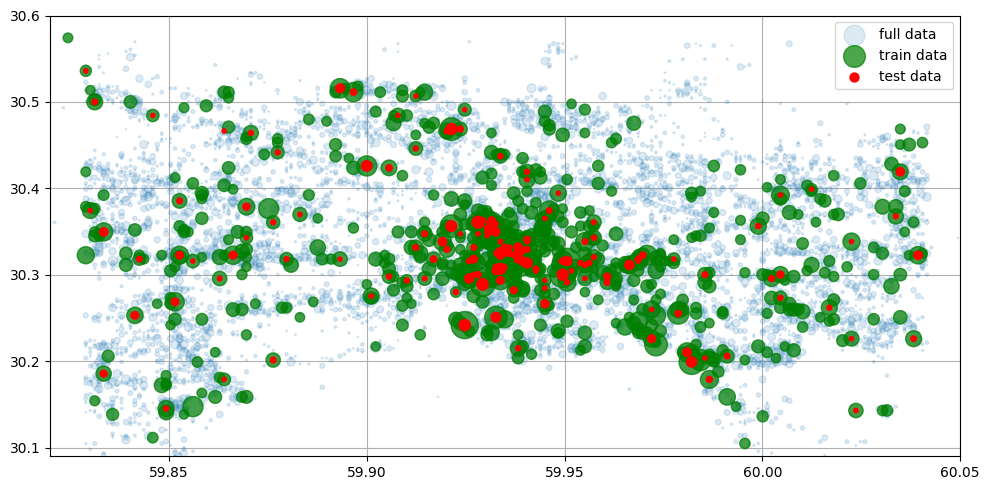

In [18]:
full_plot = data_full.groupby(['lon', 'lat']).posts_count.sum().reset_index()
to_plot = data.groupby(['lon', 'lat']).posts_count.sum().reset_index()
test_plot = test.groupby(['lon', 'lat'])['sum'].sum().reset_index()

fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(full_plot.lat, full_plot.lon, s=np.sqrt(full_plot.posts_count), alpha=0.15, zorder=10, label='full data')
ax.scatter(to_plot.lat, to_plot.lon, s=np.sqrt(to_plot.posts_count), color='g', alpha=0.7, zorder=10, label='train data')
ax.scatter(test_plot.lat, test_plot.lon, s=np.sqrt(test_plot['sum']) * 4, color='r', zorder=10, label='test data')
ax.set_xlim(59.82, 60.05)
ax.set_ylim(30.09, 30.6)
ax.grid(zorder=0)
ax.legend()
fig.tight_layout()

## Test data prepare

In [20]:
test_data = test[['timestamp', 'lat', 'lon']].copy()
test_data['posts_count'] = None
test_data['datetime'] = test_data['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x))
test_data = test_data.set_index('datetime')
test_data = test_data.sort_index()
test_data

,timestamp,lat,lon,posts_count
datetime,,,,
2020-02-01 12:00:00,1580536800,59.931487,30.354073,None
2020-02-01 12:00:00,1580536800,59.893208,30.515770,None
2020-02-01 14:00:00,1580544000,59.921359,30.356319,None
2020-02-01 16:00:00,1580551200,59.982083,30.199114,None
2020-02-01 16:00:00,1580551200,60.039332,30.322632,None
...,...,...,...,...
2020-03-01 01:00:00,1583002800,59.921359,30.468609,None
2020-03-01 01:00:00,1583002800,59.934863,30.342845,None
2020-03-01 01:00:00,1583002800,60.022505,30.338353,None


In [21]:
full_data = data.append(test_data)

C:\Users\Barkovskii\AppData\Local\Temp\ipykernel_15816\3965580269.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_data = data.append(test_data)


In [22]:
def add_features(df, featue_cols):
    def get_sin_cos(col, period, name):
        return pd.DataFrame(
            {f'{name}_sin': np.sin(col / period * 2 * np.pi), 
             f'{name}_cos': np.cos(col / period * 2 * np.pi)})
    
    # time features
    hour_features = get_sin_cos(df.index.hour, 24, 'hour').set_index(df.index)
    week_features = get_sin_cos(df.index.weekday, 7, 'weekday').set_index(df.index)
    year_features = get_sin_cos(df.index.day_of_year, 365, 'yearday').set_index(df.index)
    
    # lag features
    dates_lag_stats = df.groupby(df.index)[featue_cols].agg(['max', 'mean', 'min', 'std']).shift(hp['known_lag'])
    dates_lag_stats.columns = [f'lag_{name1}_{name2}' for name1, name2 in dates_lag_stats.columns]
    
    df = df.merge(dates_lag_stats, left_index=True, right_index=True)
    return pd.concat([df, hour_features, week_features, year_features], axis=1)

In [23]:
feature_columns = full_data.columns[3:]

In [24]:
%%time
full_data = add_features(full_data, feature_columns).drop(columns=feature_columns[feature_columns != 'posts_count'])

C:\Users\Barkovskii\AppData\Local\Temp\ipykernel_15816\2409060322.py:13: FutureWarning: ['date'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  dates_lag_stats = df.groupby(df.index)[featue_cols].agg(['max', 'mean', 'min', 'std']).shift(hp['known_lag'])


CPU times: total: 10.8 s
Wall time: 11.4 s


In [25]:
train_data = full_data.iloc[:len(data)]
test_data = full_data.iloc[len(data):]

## train / test split

In [26]:
val_start = dt.datetime(2020, 1, 10, 0)
columns = train_data.columns
features = columns[columns != 'posts_count']
target = 'posts_count'

train_x = train_data.loc[:val_start - dt.timedelta(hours=1), features]
val_x = train_data.loc[val_start:, features]
train_y = np.log(train_data.loc[:val_start - dt.timedelta(hours=1), target].astype('float'))
val_y = np.log(train_data.loc[val_start:, target].astype('float'))

In [51]:
val_x.index.max() - val_x.index.min()

Timedelta('22 days 05:00:00')

In [27]:
train = lgbm.Dataset(train_x, train_y)
val = lgbm.Dataset(val_x, val_y)

In [28]:
def objective(trial):
    params = {}
    params['num_leaves'] = trial.suggest_int('num_leaves', 2, 512)
    params['max_depth'] = trial.suggest_int('max_depth', 4, 32)
    params['min_child_weight'] = trial.suggest_int('min_child_weight', 1, 16)
    params['feature_fraction'] = trial.suggest_uniform('feature_fraction', 0.4, 1.0)
    params['bagging_fraction'] = trial.suggest_uniform('bagging_fraction', 0.4, 1.0)
    params['bagging_freq'] = trial.suggest_int('bagging_freq', 1, 8)
    params['lambda_l1'] = trial.suggest_loguniform('lambda_l1', 1e-8, 1.0)
    params['lambda_l2'] = trial.suggest_loguniform('lambda_l2', 1e-8, 1.0)
    params['num_boost_round'] = trial.suggest_int('num_boost_round', 10, 500)
    params.update({
        'metric': hp['metric'],
        'boosting_type': 'gbdt',
        'early_stopping_rounds': 10,
        'verbosity': -1,
        'random_state': 42,
    })
    
    model = lgbm.train(params, train, valid_sets=[val], verbose_eval=False)
    return model.best_score['valid_0'][hp['metric']]

In [29]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,
    n_trials=hp['n_val_trials'],
)

[I 2022-11-11 23:21:54,423] A new study created in memory with name: no-name-25e819bf-03cb-495b-87df-d8104855c12d
C:\Users\Barkovskii\AppData\Local\Temp\ipykernel_15816\423802598.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  params['feature_fraction'] = trial.suggest_uniform('feature_fraction', 0.4, 1.0)
C:\Users\Barkovskii\AppData\Local\Temp\ipykernel_15816\423802598.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  params['bagging_fraction'] = trial.suggest_uniform('bagging_fraction', 0.4, 1.0)
C:\Users\Barkovskii\AppData\Local\Temp\ipykernel_15816\423802598.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature

In [88]:
pd.DataFrame.from_dict?

In [93]:
pd.DataFrame.from_dict(study.best_params, orient='index').rename(columns={0: 'lgbm hyperparams'})

,lgbm hyperparams
num_leaves,463.000000
max_depth,17.000000
min_child_weight,3.000000
feature_fraction,0.713109
bagging_fraction,0.824923
bagging_freq,4.000000
lambda_l1,0.000038
lambda_l2,0.000005
num_boost_round,182.000000


In [30]:
params = {
    "metric": "rmse",
    "boosting_type": "gbdt",
    "early_stopping_rounds": 10,
    "verbosity": -1,
    "random_state": 42,
}

In [31]:
params.update(study.best_params)

In [32]:
model = lgbm.train(params, train, valid_sets=[val], verbose_eval=False)

In [33]:
preds = np.exp(model.predict(val_x))
'Validation MAE: ' + str(mean_absolute_error(np.exp(val_y), preds))

'Validation MAE: 1.4944186247199018'

In [34]:
final_result = test_data.merge(test[['timestamp', 'lon', 'lat', 'sum']], on=['timestamp', 'lon', 'lat'])

In [35]:
preds = np.exp(model.predict(final_result[features]))

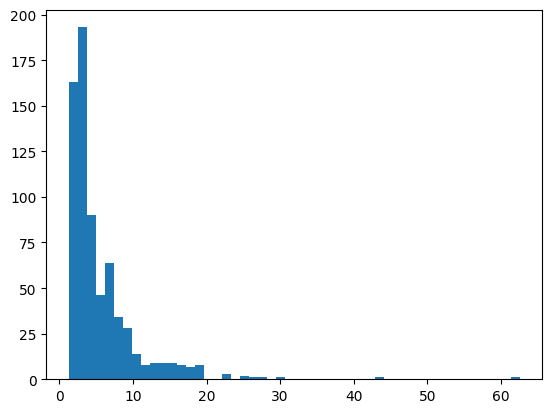

In [36]:
plt.hist(preds, bins=50);

In [37]:
final_result['pred'] = np.round(np.maximum(preds, 5))
# final_result['pred'] = np.round(preds)

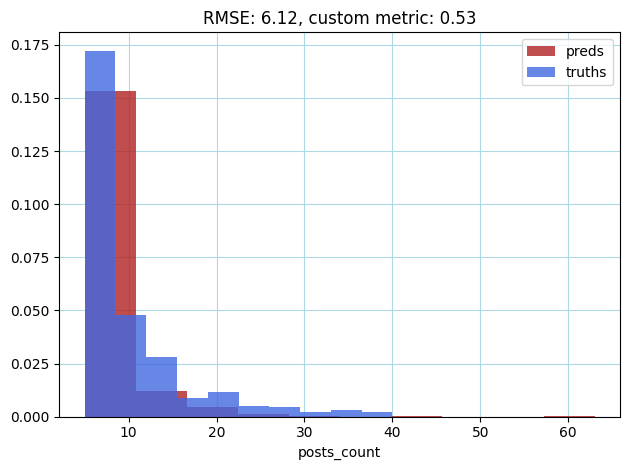

In [77]:
fig, ax = plt.subplots()

rmse = np.sqrt(np.mean((final_result['pred'] - final_result['sum'])**2))
custom_metric = ((final_result['pred'] - final_result['sum']).abs() / final_result['pred']).mean()

ax.hist(final_result['pred'], alpha=0.8, color='firebrick', zorder=2, label='preds', density=True)
ax.hist(final_result['sum'], alpha=0.8, color='royalblue', zorder=2, label='truths', density=True)
ax.grid(color='lightblue', zorder=0)
ax.legend()
ax.set_xlabel('posts_count')
ax.set_title(f'RMSE: {rmse:.2f}, custom metric: {custom_metric:.2f}')
fig.tight_layout()

<AxesSubplot: >

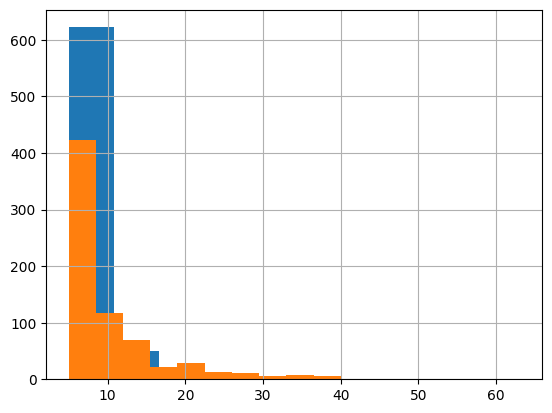

In [54]:
final_result['pred'].hist()
final_result['sum'].hist()

In [43]:
final_result[['timestamp', 'lon', 'lat', 'pred']].to_csv('test_pred.csv')

In [44]:
final_result

,timestamp,lon,lat,posts_count,lag_likescount_mean_max,lag_likescount_mean_mean,lag_likescount_mean_min,lag_likescount_mean_std,lag_likescount_std_max,lag_likescount_std_mean,lag_likescount_std_min,lag_likescount_std_std,lag_likescount_amin_max,lag_likescount_amin_mean,lag_likescount_amin_min,lag_likescount_amin_std,lag_likescount_amax_max,lag_likescount_amax_mean,lag_likescount_amax_min,lag_likescount_amax_std,lag_posts_count_max,lag_posts_count_mean,lag_posts_count_min,lag_posts_count_std,lag_commentscount_mean_max,lag_commentscount_mean_mean,lag_commentscount_mean_min,lag_commentscount_mean_std,lag_commentscount_std_max,lag_commentscount_std_mean,lag_commentscount_std_min,lag_commentscount_std_std,lag_commentscount_amin_max,lag_commentscount_amin_mean,lag_commentscount_amin_min,lag_commentscount_amin_std,lag_commentscount_amax_max,lag_commentscount_amax_mean,lag_commentscount_amax_min,lag_commentscount_amax_std,lag_symbols_cnt_mean_max,lag_symbols_cnt_mean_mean,lag_symbols_cnt_mean_min,lag_symbols_cnt_mean_std,lag_symbols_cnt_std_max,lag_symbols_cnt_std_mean,lag_symbols_cnt_std_min,lag_symbols_cnt_std_std,lag_symbols_cnt_amin_max,lag_symbols_cnt_amin_mean,lag_symbols_cnt_amin_min,lag_symbols_cnt_amin_std,lag_symbols_cnt_amax_max,lag_symbols_cnt_amax_mean,lag_symbols_cnt_amax_min,lag_symbols_cnt_amax_std,lag_words_cnt_mean_max,lag_words_cnt_mean_mean,lag_words_cnt_mean_min,lag_words_cnt_mean_std,lag_words_cnt_std_max,lag_words_cnt_std_mean,lag_words_cnt_std_min,lag_words_cnt_std_std,lag_words_cnt_amin_max,lag_words_cnt_amin_mean,lag_words_cnt_amin_min,lag_words_cnt_amin_std,lag_words_cnt_amax_max,lag_words_cnt_amax_mean,lag_words_cnt_amax_min,lag_words_cnt_amax_std,lag_hashtags_cnt_mean_max,lag_hashtags_cnt_mean_mean,lag_hashtags_cnt_mean_min,lag_hashtags_cnt_mean_std,lag_hashtags_cnt_std_max,lag_hashtags_cnt_std_mean,lag_hashtags_cnt_std_min,lag_hashtags_cnt_std_std,lag_hashtags_cnt_amin_max,lag_hashtags_cnt_amin_mean,lag_hashtags_cnt_amin_min,lag_hashtags_cnt_amin_std,lag_hashtags_cnt_amax_max,lag_hashtags_cnt_amax_mean,lag_hashtags_cnt_amax_min,lag_hashtags_cnt_amax_std,lag_mentions_cnt_mean_max,lag_mentions_cnt_mean_mean,lag_mentions_cnt_mean_min,lag_mentions_cnt_mean_std,lag_mentions_cnt_std_max,lag_mentions_cnt_std_mean,lag_mentions_cnt_std_min,lag_mentions_cnt_std_std,lag_mentions_cnt_amin_max,lag_mentions_cnt_amin_mean,lag_mentions_cnt_amin_min,lag_mentions_cnt_amin_std,lag_mentions_cnt_amax_max,lag_mentions_cnt_amax_mean,lag_mentions_cnt_amax_min,lag_mentions_cnt_amax_std,lag_links_cnt_mean_max,lag_links_cnt_mean_mean,lag_links_cnt_mean_min,lag_links_cnt_mean_std,lag_links_cnt_std_max,lag_links_cnt_std_mean,lag_links_cnt_std_min,lag_links_cnt_std_std,lag_links_cnt_amin_max,lag_links_cnt_amin_mean,lag_links_cnt_amin_min,lag_links_cnt_amin_std,lag_links_cnt_amax_max,lag_links_cnt_amax_mean,lag_links_cnt_amax_min,lag_links_cnt_amax_std,lag_emoji_cnt_mean_max,lag_emoji_cnt_mean_mean,lag_emoji_cnt_mean_min,lag_emoji_cnt_mean_std,lag_emoji_cnt_std_max,lag_emoji_cnt_std_mean,lag_emoji_cnt_std_min,lag_emoji_cnt_std_std,lag_emoji_cnt_amin_max,lag_emoji_cnt_amin_mean,lag_emoji_cnt_amin_min,lag_emoji_cnt_amin_std,lag_emoji_cnt_amax_max,lag_emoji_cnt_amax_mean,lag_emoji_cnt_amax_min,lag_emoji_cnt_amax_std,hour_sin,hour_cos,weekday_sin,weekday_cos,yearday_sin,yearday_cos,sum,pred
0,1580536800,30.354073,59.931487,None,2071.0,68.211198,1.0,200.219531,3546.422282,54.229887,0.0,340.996402,279.0,35.469565,0.0,46.408809,6166.0,139.991304,1.0,606.713240,17.0,1.956522,1.0,2.202038,15.200000,1.208596,0.0,2.403546,32.337285,0.841384,0.0,3.473525,11.0,0.686957,0.0,1.591453,73.0,2.330435,0.0,7.497042,1390.0,147.546142,0.0,240.944397,1350.573952,90.939733,0.0,224.978234,1334.0,83.643478,0.0,173.154540,2160.0,238.617391,0.0,397.600182,139.5,11.632450,0.0,23.172667,144.956890,8.133478,0.0,21.495580,123.0,6.008696,0.0,16.040243,215.0,19.495652,0.0,37.709270,29.0,2.299525,0.0,4.742983,17.677670,1.156241,0.0,3.013903,29.0,1.460870,0.0,4.365509,30

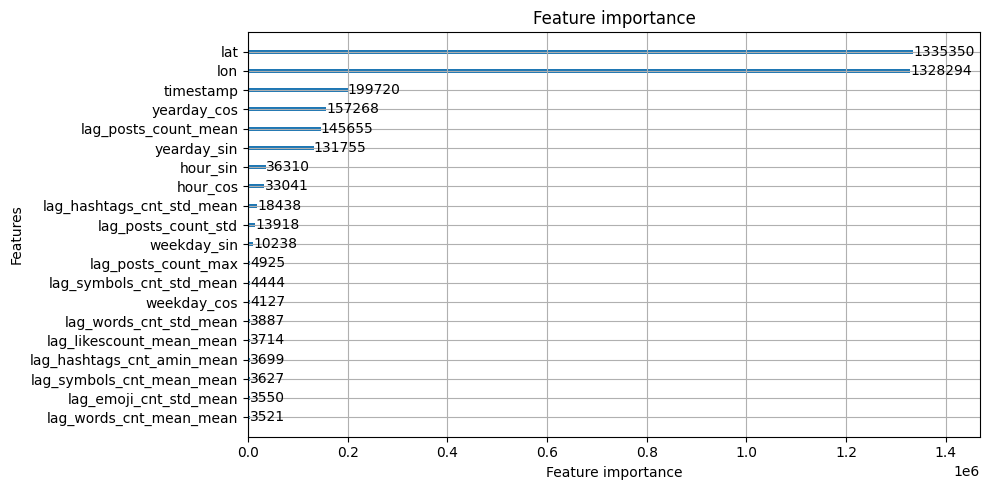

In [80]:
ax = lgbm.plot_importance(model, importance_type='gain', figsize=(10,5), max_num_features=20, precision=0, )
plt.tight_layout()

These cells were executed in Kaggle notebooks. The result image is in current directory

In [ ]:
dates = pd.DataFrame(pd.date_range(dt.datetime(2020, 2, 1, 0), dt.datetime(2020, 2, 28, 23), freq='H'), columns=['datetime'])
dates['key'] = 0
poly['key'] = 0

new_test = poly.merge(dates).drop(columns=['key']).set_index('datetime').sort_index()
new_test['timestamp'] = new_test.index.astype('int64') // 10 ** 9
new_test = new_test[['timestamp', 'lon', 'lat']]
new_test['posts_count'] = None
new_test

In [ ]:
new_full_data = data.append(new_test)
new_full_data = add_features(new_full_data)
new_test = new_full_data.iloc[-len(new_test):]

new_preds = np.around(np.exp(model.predict(new_test[features])))
new_test['preds'] = new_preds

In [ ]:
tmp = train_data[train_data.index >= dt.datetime(2020, 1, 1, 0)]
lonlat = tmp.groupby(['lon', 'lat']).posts_count.sum().sort_values().reset_index()
lonlat = lonlat[lonlat.posts_count > 200].reset_index(drop=True)

In [ ]:
plt.figure(figsize=(40, 30))
for i in range(4):
    plt.subplot(2, 2, i+1)
    cur_poly = np.random.randint(0, len(lonlat))
    tmp[(tmp.lon == lonlat.loc[cur_poly][0]) & (tmp.lat == lonlat.loc[cur_poly][1])].posts_count.plot()
    new_test[(new_test.lon == lonlat.loc[cur_poly][0]) & (new_test.lat == lonlat.loc[cur_poly][1])].preds.plot()
    plt.title(f"{round(lonlat.loc[cur_poly][0], 5)}, {round(lonlat.loc[cur_poly][1], 5)}")
plt.savefig('forecasts_examples.png', bbox_inches='tight')